<a href="https://www.kaggle.com/code/ujjwalmalik/disaster-tweet-classification-using-roberta?scriptVersionId=132741557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import re
import emoji

# Data Cleaning

In [2]:
data = pd.read_csv('/kaggle/input/disaster-tweets/tweets.csv')
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [3]:
# Loading required features
data = data[['text','target']]
data.head()

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0


In [4]:
data = data.dropna()
data.isna().sum()

text      0
target    0
dtype: int64

In [5]:
data['text'] = [entry.lower() for entry in data['text']]
data['text'].head()

0    communal violence in bhainsa, telangana. "ston...
1    telangana: section 144 has been imposed in bha...
2    arsonist sets cars ablaze at dealership https:...
3    arsonist sets cars ablaze at dealership https:...
4    "lord jesus, your love brings freedom and pard...
Name: text, dtype: object

In [7]:
def remove_urls(text):
    pattern = re.compile(r'http\S+|www\S+')
    return pattern.sub('', text)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    return pattern.sub('', text)

def remove_hashtags(text):
    pattern = re.compile(r'#\w+')
    return pattern.sub('', text)

def remove_emojis(text):
    return emoji.demojize(text)

In [8]:
def preprocess_text(text):
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = remove_hashtags(text)
    text = remove_emojis(text)
    return text

In [9]:
data['text'] = data['text'].apply(preprocess_text)
data

,text,target
0,communal violence in bhainsa telangana stones ...,1
1,telangana section 144 has been imposed in bhai...,1
2,arsonist sets cars ablaze at dealership,1
3,arsonist sets cars ablaze at dealership,1
4,lord jesus your love brings freedom and pardon...,0
...,...,...
11365,media should have warned us well in advance th...,0
11366,i feel directly attacked i consider moonbin a...,0
11367,i feel directly attacked i consider moonbin a...,0
11368,ok who remember outcast nd the dora au those a...,0


In [10]:
data = data[data['text'].map(len) > 0]
class_counts = data['target'].value_counts()
print(class_counts)

0    9254
1    2114
Name: target, dtype: int64


# Classification using RoBERTa

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, RobertaConfig

In [20]:
# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data['text'],
    data['target'],
    test_size=0.2,
    random_state=42
)



In [21]:
# Load pre-trained RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input texts
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_data.tolist(), truncation=True, padding=True)

In [22]:
# Create custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.encodings['input_ids'])
    
    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[index])
        return item

In [23]:
# Create training and validation datasets
train_dataset = TextDataset(train_encodings, train_labels.tolist())
val_dataset = TextDataset(val_encodings, val_labels.tolist())

In [51]:
# Define the model configuration
model_config = RobertaConfig.from_pretrained('roberta-base', num_labels=2)
model_config.hidden_dropout_prob = 0.2  # Dropout probability'

# Create a data loader for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=model_config)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [53]:
from sklearn.metrics import accuracy_score, f1_score

num_epochs = 20  # Define the number of epochs

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    predictions = []
    true_labels = []

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted_labels = torch.max(outputs.logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted_labels == labels).sum().item()

        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())

    train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * train_correct / train_total
    train_f1 = f1_score(true_labels, predictions)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            _, predicted_labels = torch.max(outputs.logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted_labels == labels).sum().item()

            val_predictions.extend(predicted_labels.tolist())
            val_true_labels.extend(labels.tolist())

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * val_correct / val_total
    val_f1 = f1_score(val_true_labels, val_predictions)

    print(f"Epoch: {epoch + 1}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.2f}% | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Train F1-score: {train_f1:.4f} | Validation F1-score: {val_f1:.4f}")

Epoch: 1
Train Loss: 0.2952 | Validation Loss: 0.2667
Train Accuracy: 88.23% | Validation Accuracy: 89.05%
Train F1-score: 0.6455 | Validation F1-score: 0.7308
Epoch: 2
Train Loss: 0.2306 | Validation Loss: 0.2466
Train Accuracy: 90.85% | Validation Accuracy: 90.33%
Train F1-score: 0.7424 | Validation F1-score: 0.7489
Epoch: 3
Train Loss: 0.1860 | Validation Loss: 0.3142
Train Accuracy: 92.47% | Validation Accuracy: 87.73%
Train F1-score: 0.7892 | Validation F1-score: 0.7229
Epoch: 4
Train Loss: 0.1558 | Validation Loss: 0.2599
Train Accuracy: 93.89% | Validation Accuracy: 89.75%
Train F1-score: 0.8339 | Validation F1-score: 0.7397
Epoch: 5
Train Loss: 0.1295 | Validation Loss: 0.2853
Train Accuracy: 95.18% | Validation Accuracy: 89.01%
Train F1-score: 0.8697 | Validation F1-score: 0.7306
Epoch: 6
Train Loss: 0.1066 | Validation Loss: 0.2940
Train Accuracy: 96.11% | Validation Accuracy: 89.58%
Train F1-score: 0.8964 | Validation F1-score: 0.7410
Epoch: 7
Train Loss: 0.0870 | Validation

In [54]:
# Evaluate on the test set
test_data = pd.read_csv('/kaggle/input/disaster-tweets/tweets.csv')
test_data['text'] = test_data['text'].apply(preprocess_text)
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True)
test_dataset = TextDataset(test_encodings, test_data['target'].tolist())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1).tolist()
        test_predictions.extend(predictions)

test_data['predicted_target'] = test_predictions
test_data[['text', 'predicted_target']].to_csv('test_predictions.csv', index=False)

Test Accuracy: 96.94%
Test F1-score: 0.9206


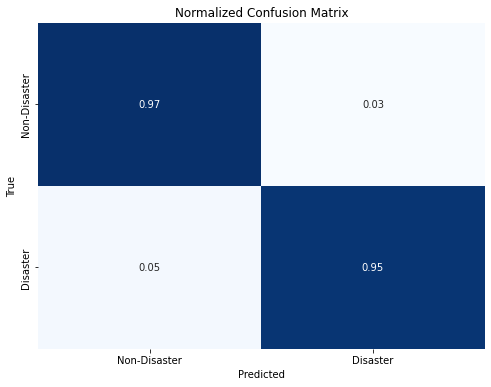

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_true_labels = test_data['target'].tolist()
test_predicted_labels = test_data['predicted_target'].tolist()

# Calculate F1-score and accuracy
test_f1 = f1_score(test_true_labels, test_predicted_labels)
test_accuracy = accuracy_score(test_true_labels, test_predicted_labels) * 100

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1-score: {test_f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)
classes = ['Non-Disaster', 'Disaster']

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

In [56]:
# Define a list of input texts
input_texts = [
    "Communal violence in Bhainsa, Telangana. Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze…",
    "Lord Jesus, your love brings freedom and pardon. Fill me with your Holy Spirit and set my heart ablaze with your l… https://t.co/VlTznnPNi8",
    "Juwan Johnson/Oregon is one big dude. Looks like a tight end stuck in the receiver group by accident.",
    "Telangana: Section 144 has been imposed in Bhainsa from January 13 to 15, after clash erupted between two groups on January 12. ",
    "Kumera yellow Aftershock #PH19FOSSIL featured in bankbtn Good Living magazine Photography Stylist shino… https://t.co/V9LJ65ttzR"
]

expected = [
    "Disaster", "Not Disaster", "Not Disaster", "Disaster", "Not Disaster"
]

# Preprocess the input texts
preprocessed_texts = [preprocess_text(text) for text in input_texts]
input_encodings = tokenizer(preprocessed_texts, truncation=True, padding=True)
input_dataset = TextDataset(input_encodings, None)
input_loader = DataLoader(input_dataset, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():
    for i, batch in enumerate(input_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1).tolist()
        prediction = 'Disaster' if predictions[0] == 1 else 'Not Disaster'
        print(f"Input: {input_texts[i]}")
        print(f"Target: {expected[i]}")
        print(f"Prediction: {prediction}")
        print()

Input: Communal violence in Bhainsa, Telangana. Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze…
Target: Disaster
Prediction: Disaster

Input: Lord Jesus, your love brings freedom and pardon. Fill me with your Holy Spirit and set my heart ablaze with your l… https://t.co/VlTznnPNi8
Target: Not Disaster
Prediction: Not Disaster

Input: Juwan Johnson/Oregon is one big dude. Looks like a tight end stuck in the receiver group by accident.
Target: Not Disaster
Prediction: Not Disaster

Input: Telangana: Section 144 has been imposed in Bhainsa from January 13 to 15, after clash erupted between two groups on January 12. 
Target: Disaster
Prediction: Disaster

Input: Kumera yellow Aftershock #PH19FOSSIL featured in bankbtn Good Living magazine Photography Stylist shino… https://t.co/V9LJ65ttzR
Target: Not Disaster
Prediction: Not Disaster

